# Despacho de energía
* Francisco
* Yeira Liseth Rodríguez Rodríguez
A continuación se presenta el tercer ejercicio del capítulo 3 de la materia de Inteligencia Artificial y mini-robots

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

#### 1. Parámetros del problema
Cuatro plantas con capacidad máxima en GW y cuatro ciudades con demanda en GW. También se establece la matriz de costos de transporte por GW de cada planta a cada ciudad, en donde cada fila representa una planta, cada columna una ciudad.

In [ ]:
# Datos
capacidad = np.array([3, 6, 5, 4])  # por planta
demanda = np.array([4, 3, 5, 3])    # por ciudad

transporte = np.array([
    [1, 4, 3, 6],
    [4, 1, 4, 5],
    [3, 4, 1, 4],
    [6, 5, 4, 1]
])

También se guara el costo de generar 1 GW por planta (por ahora se simplifica como si fuera lineal). Se usa reshape(-1,1) para que se pueda sumar por elemento a la matriz de transporte.

In [ ]:
generacion = np.array([680, 720, 660, 750])  # por planta
total_generacion = generacion.reshape(-1, 1)  # para sumarlo con transporte

Posteriormente se definen los parámetros del AG, es decir, el tamaño de la población (número de soluciones en cada generación), el número de generaciones que se simulan y la probabilidad de mutación (aunque no se usa directamente en este código, la mutación siempre se aplica al crear nuevos hijos).

In [ ]:
# AG parámetros
tam_poblacion = 100
generaciones = 200
prob_mutacion = 0.1

#### 2. Crear individuos
La función `crear_individuo()` genera soluciones válidas iniciales representadas como matrices de 4x4, donde cada elemento indica cuánta energía una planta envía a una ciudad.

In [ ]:
# Crear individuo válido
def crear_individuo():
    asignacion = np.zeros((4, 4), dtype=int)
    cap_rest = capacidad.copy()
    dem_rest = demanda.copy()

    for j in range(4):  # por ciudad
        while dem_rest[j] > 0:
            posibles = [i for i in range(4) if cap_rest[i] > 0]
            i = random.choice(posibles)
            envio = min(cap_rest[i], dem_rest[j], 1)
            asignacion[i][j] += envio
            cap_rest[i] -= envio
            dem_rest[j] -= envio
    return asignacion

#### 3. Función de evaluación
La función `evaluar(ind)` calcula el costo total de una solución sumando los costos de transporte y generación para cada unidad de energía enviada.
Se hace una suma elemento a elemento entre la matriz de asignación y la suma de las matrices de costos de transporte y generación, lo que da como resultado el costo total de la solución.

In [ ]:
# Evaluación de costo total
def evaluar(ind):
    return np.sum(ind * (transporte + total_generacion))

#### 4. Función de mutación
La función `mutar(ind) `realiza pequeñas modificaciones a una solución existente para generar una nueva variante.

In [ ]:
# Mutación: cambiar 1 unidad aleatoriamente entre celdas
def mutar(ind):
    nuevo = ind.copy()
    i1, j1 = random.randint(0, 3), random.randint(0, 3)
    if nuevo[i1][j1] > 0:
        i2 = random.choice([x for x in range(4) if x != i1])
        if capacidad[i2] - nuevo[i2].sum() > 0:
            nuevo[i1][j1] -= 1
            nuevo[i2][j1] += 1
    return reparar(nuevo)


#### 5. Reparación de solución
`reparar(asig)` ajusta una solución mutada o construida para que cumpla con las restricciones del problema. Primero verifica que ninguna planta exceda su capacidad reduciendo el exceso de energía enviada; después, garantiza que la demanda de cada ciudad esté completamente cubierta añadiendo energía desde plantas que aún tienen capacidad disponible.

In [ ]:
# Reparar restricciones
def reparar(asig):
    asig = asig.copy()
    for i in range(4):
        exceso = asig[i].sum() - capacidad[i]
        while exceso > 0:
            j = np.argmax(asig[i])
            quitar = min(exceso, asig[i][j])
            asig[i][j] -= quitar
            exceso -= quitar

    for j in range(4):
        faltante = demanda[j] - asig[:, j].sum()
        while faltante > 0:
            i = np.argmin(asig[:, j])
            posible = min(faltante, capacidad[i] - asig[i].sum())
            if posible > 0:
                asig[i][j] += posible
                faltante -= posible
            else:
                break
    return asig

#### 6. Algoritmo genético principal
En el bucle principal se simulan las generaciones. Se inicializa la población con soluciones válidas y, en cada generación, se evalúa el costo de cada individuo. Se selecciona el mejor (élite) y se asegura su paso a la siguiente generación. Luego, se generan nuevos individuos mutando a miembros aleatorios de la población.

In [ ]:
# AG principal
poblacion = [crear_individuo() for _ in range(tam_poblacion)]
mejores = []

for gen in range(generaciones):
    fitness = [evaluar(ind) for ind in poblacion]
    elite = poblacion[np.argmin(fitness)]
    mejores.append(min(fitness))
    nueva = [elite.copy()]  # elitismo

    while len(nueva) < tam_poblacion:
        padre = random.choice(poblacion)
        hijo = mutar(padre)
        nueva.append(hijo)

    poblacion = nueva


#### 7. Resultado final y visualización
Al final del proceso evolutivo, se identifica e imprime la mejor solución encontrada (el despacho óptimo de energía de planta a ciudad) junto con su costo total mínimo. Además, se grafica la evolución del mejor costo en el tiempo, mostrando cómo el algoritmo converge hacia soluciones más eficientes a medida que avanza la optimización.

Despacho óptimo (GW de planta a ciudad):

[[3 0 0 0]
 [1 3 2 0]
 [0 0 3 2]
 [0 0 0 1]]

Costo total mínimo: 10440


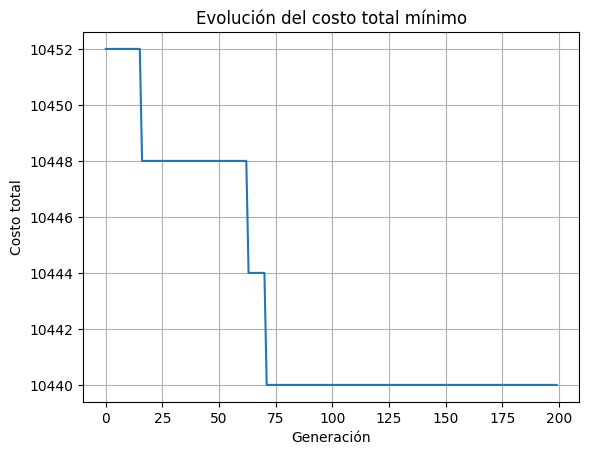

In [ ]:
# Resultado final
mejor = min(poblacion, key=evaluar)
print("Despacho óptimo (GW de planta a ciudad):\n")
print(mejor)
print("\nCosto total mínimo:", evaluar(mejor))

# Gráfica
plt.plot(mejores)
plt.title("Evolución del costo total mínimo")
plt.xlabel("Generación")
plt.ylabel("Costo total")
plt.grid(True)
plt.show()


Esto significa que, entre todas las asignaciones posibles que respetan las restricciones, el algoritmo encontró una solución con costo total mínimo de 10,440 unidades monetarias, combinando transporte y generación.

La gráfica en escalón también indica que se preservó el mejor individuo en cada generación (por elitismo).